In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
from math import *
import seaborn as sns
#from mpl_toolkits.basemap import Basemap

### Malpractice Data:

In [2]:
data = pd.read_csv('NpdbPublicUseDataCsv/NPDB1710.CSV',delimiter=',',low_memory=False)

In [3]:
## Clean the payment column so it's numeric:
data["PAYMENT"].replace('[\$,]', '', regex=True, inplace=True)

### Census/States Data:

In [4]:
state_pop = pd.read_excel('nst-est2016-01.xlsx',header=3,skip_footer=5)

new_index_list = {}
for s_label in state_pop.index:
    try:
        if s_label[0]=='.':
            new_index_list.update({s_label: s_label[1:]})
        else:
            new_index_list.update({s_label: s_label})
    except:
        new_index_list.update({s_label: 'unknown'})

state_pop.rename(new_index_list, axis='index',inplace=True)

In [5]:
state_pop

Census  Estimates Base       2010       2011  \
United States         308745538       308758105  309348193  311663358   
Northeast              55317240        55318353   55388056   55632766   
Midwest                66927001        66929825   66978602   67153331   
South                 114555744       114563005  114863114  116061801   
West                   71945553        71946922   72118421   72815460   
Alabama                 4779736         4780131    4785492    4799918   
Alaska                   710231          710249     714031     722713   
Arizona                 6392017         6392301    6408312    6467163   
Arkansas                2915918         2916025    2921995    2939493   
California             37253956        37254522   37332685   37676861   
Colorado                5029196         5029324    5048644    5118360   
Connecticut             3574097         3574114    3579899    3589893   
Delaware                 897934          897936     899816     907924   
District of Columbia     601723          601766     605183     620477   
Florida                18801310        18804592   18849098   19096952   
Georgia                 9687653         9688680    9713521    9811610   
Hawaii                  1360301         1360301    1363945    1377864   
Idaho                   1567582         1567650    1571010    1584143   
Illinois               12830632        12831574   12841578   12860012   
Indiana                 6483802         6484136    6490528    6516480   
Iowa                    3046355         3046869    3050738    3065223   
Kansas                  2853118         2853129    2858850    2869503   
Kentucky                4339367         4339344    4348662    4369354   
Louisiana               4533372         4533479    4544996    4575404   
Maine                   1328361         1328364    1327730    1328231   
Maryland                5773552         5773786    5788584    5843603   
Massachusetts           6547629         6547813    6565524    6611923   
Michigan                9883640         9884129    9877495    9876213   
Minnesota               5303925         5303924    5311147    5348562   
Mississippi             2967297         2968103    2970322    2978162   
Missouri                5988927         5988928    5996118    6010717   
Montana                  989415          989414     990641     997821   
Nebraska                1826341         1826334    1830051    1842283   
Nevada                  2700551         2700691    2703284    2718379   
New Hampshire           1316470         1316461    1316872    1318473   
New Jersey              8791894         8791953    8803729    8841243   
New Mexico              2059179         2059198    2064756    2077756   
New York               19378102        19378110   19402640   19519529   
North Carolina          9535483         9535688    9558915    9650963   
North Dakota             672591          672591     674526     685476   
Ohio                   11536504        11536727   11540983   11544824   
Oklahoma                3751351         3751615    3759603    3786274   
Oregon                  3831074         3831072    3838048    3868031   
Pennsylvania           12702379        12702857   12712343   12744293   
Rhode Island            1052567         1052940    1053337    1052451   
South Carolina          4625364         4625410    4635943    4672637   
South Dakota             814180          814195     816325     824398   
Tennessee               6346105         6346298    6356671    6397634   
Texas                  25145561        25146100   25244310   25646389   
Utah                    2763885         2763888    2775326    2816124   
Vermont                  625741          625741     625982     626730   
Virginia                8001024         8001041    8025773    8110035   
Washington              6724540         6724545    6743226    6822520   
West Virginia           1852994         1853011    1854230    1854972   
Wisconsin 

### Some preliminary analysis:

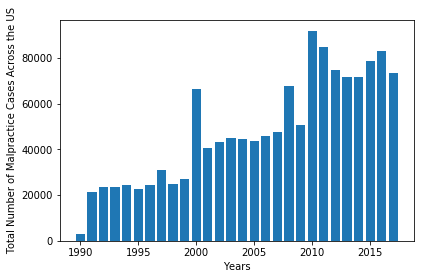

In [6]:
plt.bar(range(1990,2018),[len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)])
plt.xlabel('Years')
plt.ylabel('Total Number of Malpractice Cases Across the US')
plt.tight_layout()
plt.savefig('total_across_us.png',dpi=300)
plt.show()

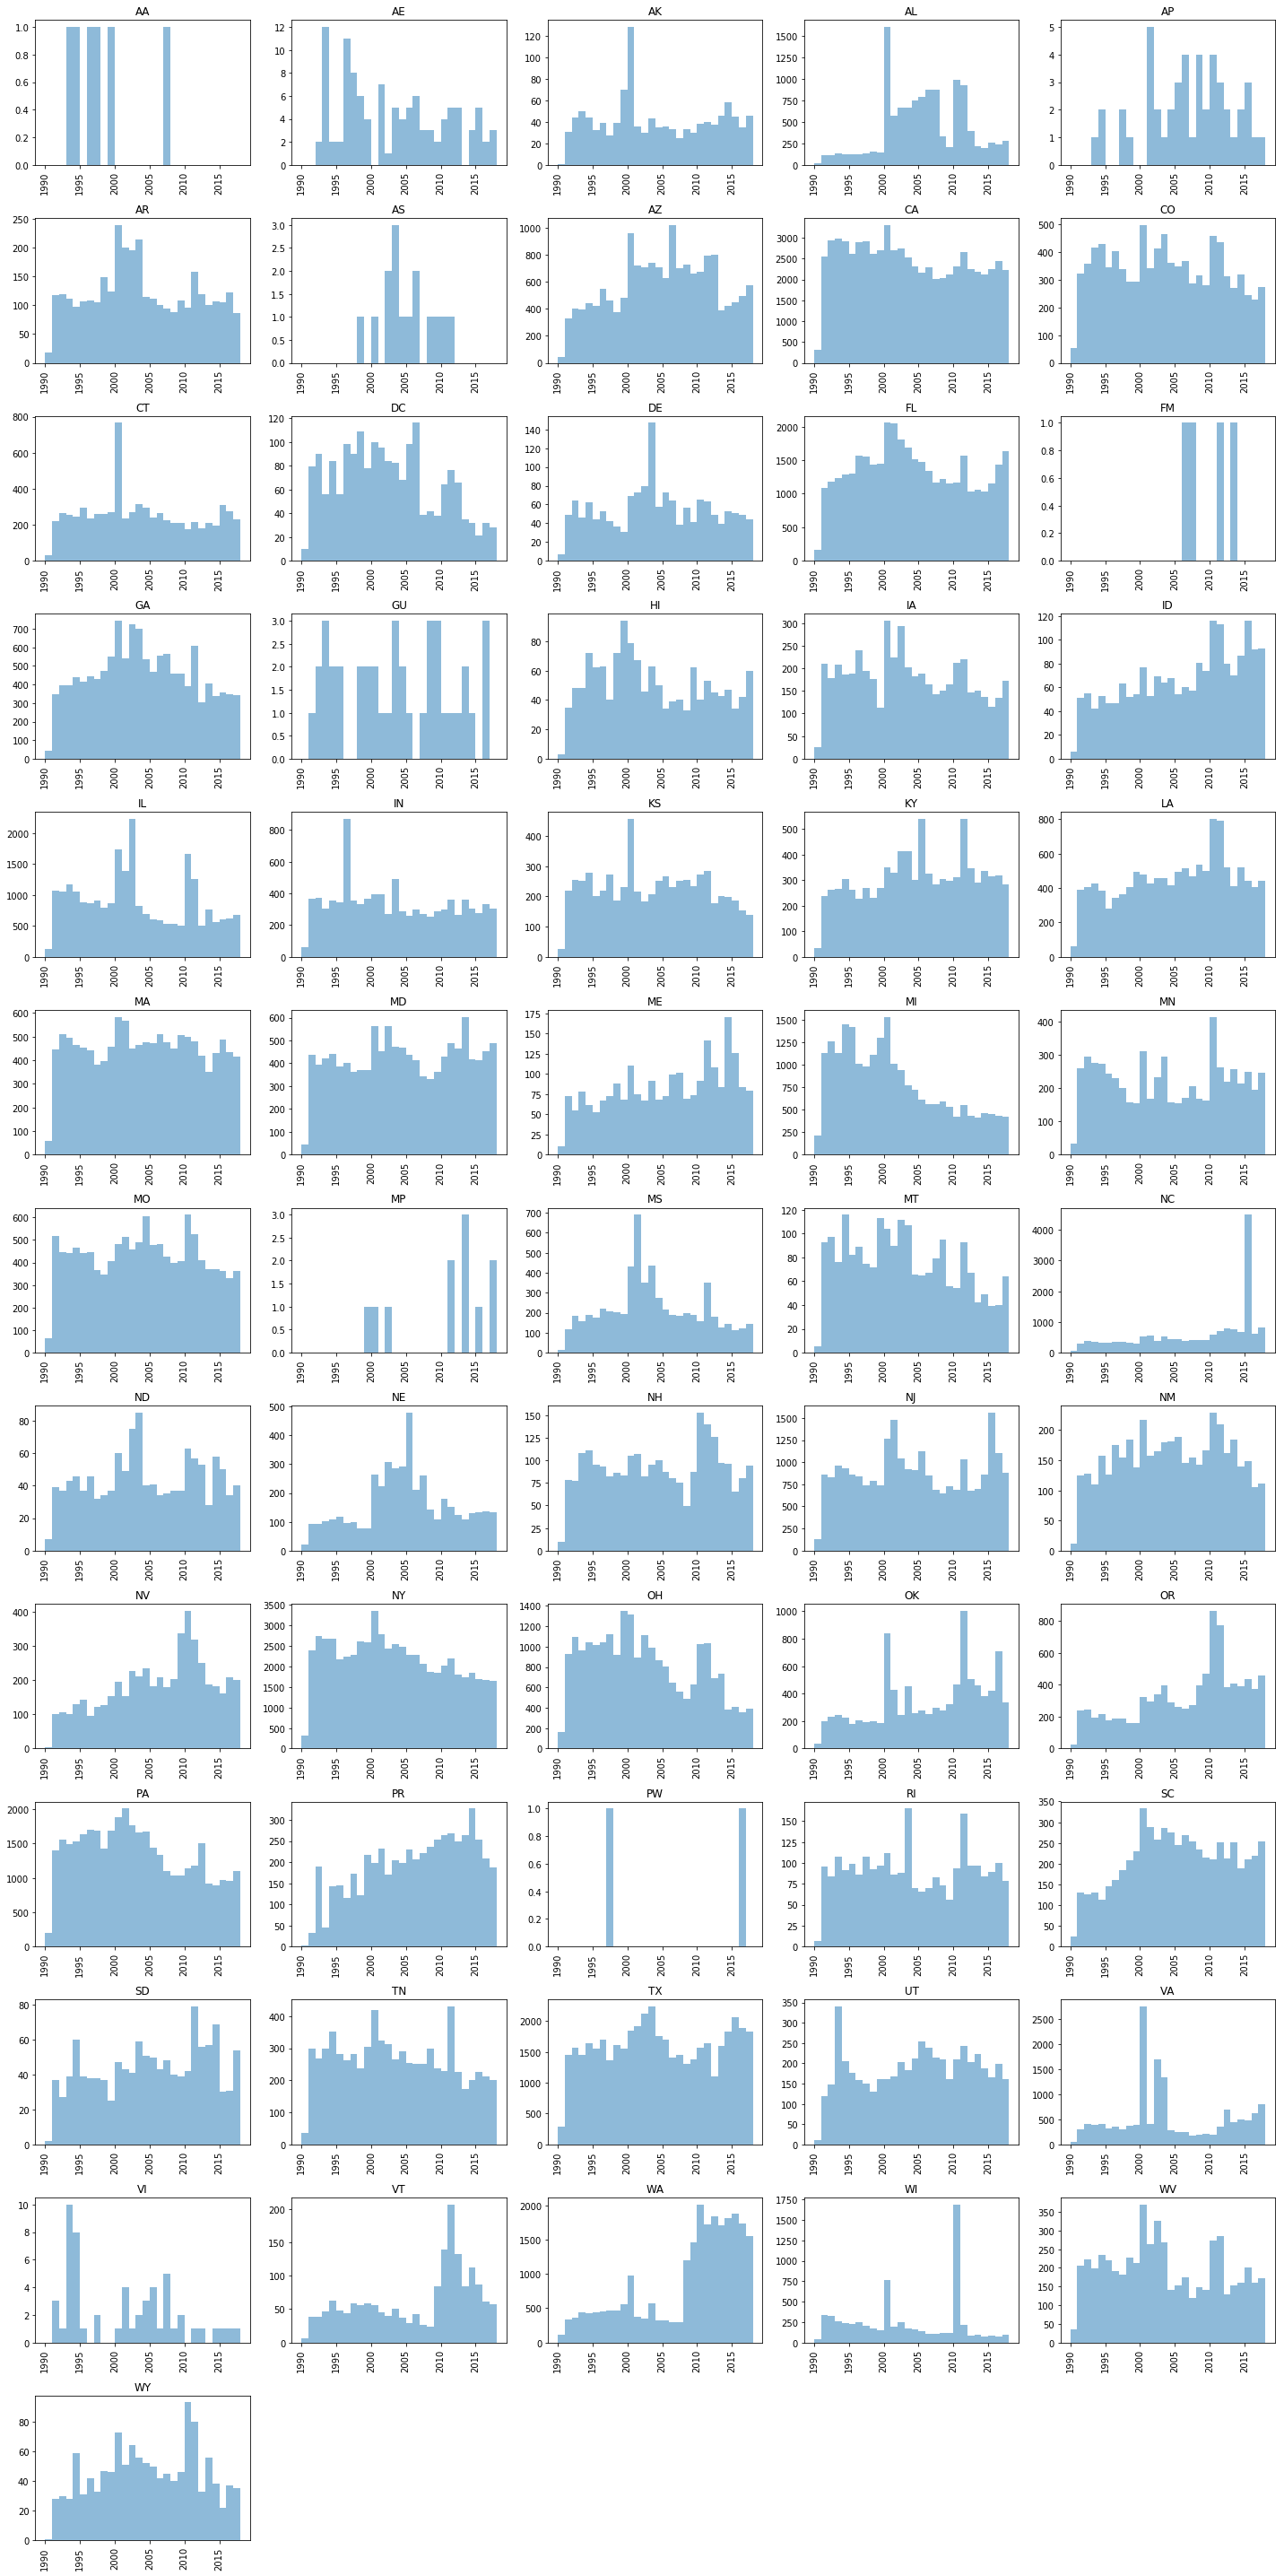

In [7]:
data.hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.xlabel('Years')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('total_per_state.png',dpi=300)
plt.show()

### Find states common to census data and malpractice data:

In [8]:
common_states = np.intersect1d(list(data["WORKSTAT"].unique()),list(state_pop["State Abb"]))

In [9]:
print(common_states,len(common_states))

['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'PR' 'RI' 'SC'
 'SD' 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY'] 52


In [10]:
print(state_pop[state_pop["State Abb"]=="CA"][2016][0])
print(state_pop[state_pop["State Abb"]=="NY"][2016][0])
print(state_pop[state_pop["State Abb"]=="PA"][2016][0])

39250017
19745289
12784227


### We start clustering analysis for the common_states in the data:

In [11]:
pay_count = None
for state in common_states:
    #print(state)
    arrays = [[state,state], ['pay_per_case', 'count_per_1000000']]
    column_names = pd.MultiIndex.from_arrays(arrays).T
    mean_payment = [pd.to_numeric(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)]['PAYMENT']).mean() for i in range(1990,2018)]
    count_per_capita = [1000000*len(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)])/state_pop[state_pop["State Abb"]==state][2016][0] for i in range(1990,2018)]
    stack = pd.DataFrame(np.stack((mean_payment,
                                   count_per_capita),axis=0).T,
                         columns=column_names,
                         index=range(1990,2018))
    #print(stack)
    if type(pay_count)==None:
        pay_count = stack
    else:
        pay_count = pd.concat([pay_count, stack], axis=1)

In [12]:
pay_count

AK                               AL                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990            NaN          1.347901  166966.666667          4.112434   
1991  196140.625000         41.784945  121558.333333         23.646495   
1992  105808.333333         59.307664  217455.555556         23.440873   
1993  130986.764706         67.395073  230903.448276         26.525199   
1994   85071.428571         59.307664  254741.666667         24.468982   
1995  178137.500000         43.132846  281157.894737         25.497090   
1996  151242.857143         52.568157  405196.236559         25.291469   
1997  158375.000000         36.393339  225808.988764         28.581416   
1998  286718.750000         52.568157  296460.674157         31.871363   
1999  270546.296296         94.353102  274947.887324         30.637633   
2000  159310.344828        172.531386  367873.529412        330.434067   
2001  240925.000000         48.524452  244472.727273        116.998746   
2002  210240.384615         40.437044  233686.781609        137.355294   
2003  241908.333333         57.959762  212584.027778        137.766537   
2004  189822.000000         47.176551  211181.818182        154.421895   
2005  737932.692308         48.524452  223898.305085        163.058006   
2006  187931.818182         44.480748  281934.375000        179.096498   
2007  482916.666667         33.697536  182864.912281        179.918985   
2008  193289.473684         44.480748  310454.545455         67.443917   
2009  229140.625000         40.437044  306960.000000         42.152448   
2010  615511.904762         51.220255  282437.500000        204.593589   
2011  419333.333333         53.916058  250020.833333        190.611313   
2012  361029.411765         49.872354  317812.500000         82.043057   
2013  289482.142857         62.003467  454377.659574         45.236773   
2014  270666.666667         78.178284  637780.172414         41.124339   
2015  334264.705882         60.655565  308533.653846         53.256020   
2016  208750.000000         47.176551  426599.000000         49.966072   
2017  251363.636364         62.003467  402366.071429         56.957210   

                 AR                               AZ                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990   81357.142857          6.023596  166171.250000          6.203947   
1991   83832.258065         39.488021  122601.452282         47.178856   
1992  226307.065217         39.822665  181994.117647         58.143972   
1993  126375.000000         37.145511  111253.600000         57.134027   
1994  116544.871795         32.795136  155957.993197         64.347920   
1995  107418.354430         35.806934  183279.904306         61.029529   
1996  105860.000000         36.476223  134880.930931         79.352816   
1997   96891.791045         35.472290  230950.825083         67.233477   
1998  178015.789474         49.861993  164200.390625         54.248470   
1999  187451.219512         41.495887  182063.586957         69.253366   
2000  225487.654321         80.314619  231539.655172        138.651011   
2001  169092.233010         67.263494  257575.301205        104.745717   
2002  226741.818182         65.590272  254643.769968        102.870105   
2003  326037.974684         71.948513  274889.041096        107.486996   
2004  261940.229885         38.484088  291361.991870        102.148716   
2005  295718.085106         37.480156  273618.580060         91.327877   
2006  213264.492754         33.464425  253462.264151        147.884793   
2007  259293.103448         31.456559  313289.676113        100.994493   
2008  319433.035714         29.448694  327817.073171        104.889995   
2009  330504.098361         36.476223  295964.508929         95.656212   
2010  291380.434783         32.125848  263381.909548         97.387547   
2011  304291.666667         53.208435  311558.849558        114.556610   
2012  252745.833333 

In [13]:
state_slope = []
for state in common_states:
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(range(1991,2018),
                                                                      pay_count[state,"count_per_1000000"][1:])
    state_slope.append([state,slope,intercept])
    
df_state_slope=pd.DataFrame(state_slope,columns=["state","slope","intercept"])
#df_state_slope #.sort_values("slope")

In [14]:
correlation_slope = np.zeros((len(common_states),len(common_states)))

for state1 in range(len(common_states)):
    for state2 in range(len(common_states)):
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"]))
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"]))
        #correlation_slope[state1,state2] = np.sqrt(((
        #    float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
        #    float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2)
        correlation_slope[state1,state2] = ((
            float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
            float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2

In [15]:
print(correlation_slope)

[[ 0.          4.96605851  0.01295486 ...  0.23402818  1.39093764
   0.46208437]
 [ 4.96605851  0.          5.48629868 ...  7.35619208 11.61341231
   2.39846434]
 [ 0.01295486  5.48629868  0.         ...  0.13685943  1.13541976
   0.6297808 ]
 ...
 [ 0.23402818  7.35619208  0.13685943 ...  0.          0.48388107
   1.3538078 ]
 [ 1.39093764 11.61341231  1.13541976 ...  0.48388107  0.
   3.45643156]
 [ 0.46208437  2.39846434  0.6297808  ...  1.3538078   3.45643156
   0.        ]]


In [16]:
from sklearn.cluster import DBSCAN
# Compute DBSCAN

db = DBSCAN(eps=0.05, min_samples=1,metric='precomputed').fit_predict(correlation_slope)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#for i in np.unique(db):
#    print(i,common_states[np.where(db==i)])
    
df_state_cluster = pd.DataFrame(db.T,columns=["cluster"])
df_state_slope_cluster = pd.concat([df_state_slope,df_state_cluster],axis=1)

average_slopes = []
for state in common_states:
    current_cluster = int(df_state_slope_cluster[df_state_slope_cluster["state"]==state]["cluster"])
    #print(current_cluster)
    average_slope = df_state_slope_cluster[df_state_slope_cluster["cluster"]==current_cluster]["slope"].mean()
    average_slopes.append(average_slope)
    
df_cluster_slope = pd.DataFrame(np.array(average_slopes).T,columns=["avg_slopes"])
df_state_slope_cluster_aslope = pd.concat([df_state_slope_cluster,df_cluster_slope],axis=1)

cluster_colors = pd.DataFrame(np.array(average_slopes).T,columns=["cl_colors"])
df_state_slope_cluster_aslope_acolor = pd.concat([df_state_slope_cluster_aslope,cluster_colors],axis=1)

start = 0
for i in np.unique(df_state_slope_cluster_aslope["avg_slopes"].sort_values()):
    #print(i)
    #print(start)
    df_state_slope_cluster_aslope_acolor.replace(to_replace= {'cl_colors': {i: start}}, inplace=True)
    start += 1

In [17]:
df_state_slope_cluster_aslope_acolor

state     slope     intercept  cluster  avg_slopes  cl_colors
0     AK -0.203255    464.733599        0   -0.128846        4.0
1     AL  2.025211  -3966.951698        1    1.949438        6.0
2     AR -0.317074    677.656642        0   -0.128846        4.0
3     AZ  0.962205  -1842.375372        0   -0.128846        4.0
4     CA -0.782451   1631.942116        0   -0.128846        4.0
5     CO -0.664984   1395.570399        0   -0.128846        4.0
6     CT -0.742375   1561.524534        0   -0.128846        4.0
7     DC -3.223822   6561.454579        2   -3.223822        1.0
8     DE -0.160951    382.493131        0   -0.128846        4.0
9     FL -0.289428    647.640492        0   -0.128846        4.0
10    GA -0.273324    593.437624        0   -0.128846        4.0
11    HI -0.442312    922.975419        0   -0.128846        4.0
12    IA -0.802200   1666.673829        0   -0.128846        4.0
13    ID  1.251005  -2465.469154        3    1.359605        5.0
14    IL -1.446617   2971.286331        4   -1.414626        3.0
15    IN -0.774970   1605.325143        0   -0.128846        4.0
16    KS -0.851088   1785.520047        0   -0.128846        4.0
17    KY  0.766673  -1464.333761        0   -0.128846        4.0
18    LA  1.385787  -2677.634499        3    1.359605        5.0
19    MA -0.172796    414.318048        0   -0.128846        4.0
20    MD  0.315273   -559.389020        0   -0.128846        4.0
21    ME  1.442024  -2825.003354        3    1.359605        5.0
22    MI -4.136127   8371.965864        5   -4.136127        0.0
23    MN -0.105733    253.300086        0   -0.128846        4.0
24    MO -0.400788    875.831210        0   -0.128846        4.0
25    MS -0.872224   1824.111421        0   -0.128846        4.0
26    MT -1.839958   3761.952250        6   -2.100304        2.0
27    NC  4.170708  -8296.200407        7    4.170708        9.0
28    ND  0.191700   -324.209241        0   -0.128846        4.0
29    NE  0.027153    -51.424946        0   -0.128846        4.0
30    NH  0.182492   -295.485903        0   -0.128846        4.0
31    NJ  0.197119   -292.699854        0   -0.128846        4.0
32    NM  0.198316   -321.144671        0   -0.128846        4.0
33    NV  1.948995  -3841.312838        1    1.949438        6.0
34    NY -2.040950   4204.397451        6   -2.100304        2.0
35    OH -2.261629   4605.071344        6   -2.100304        2.0
36    OK  3.287332  -6495.455177        8    3.301733        7.0
37    OR  3.316135  -6562.619362        8    3.301733        7.0
38    PA -2.258678   4635.782755        6   -2.100304        2.0
39    PR  1.874109  -3697.488325        1    1.949438        6.0
40    RI -0.213242    515.896149        0   -0.128846        4.0
41    SC  0.690965  -1340.790028        0   -0.128846        4.0
42    SD  0.659559  -1269.589448        0   -0.128846        4.0
43    TN -0.524569   1092.393150        0   -0.128846        4.0
44    TX  0.192884   -327.295562        0   -0.128846        4.0
45    UT  0.286521   -511.261800        0   -0.128846        4.0
46    VA -0.118518    303.298671        0   -0.128846        4.0
47    VT  3.857940  -7626.472431        9    3.857940        8.0
48    WA  9.000025 -17912.291021       10    9.000025       10.0
49    WI -0.687020   1419.536741        0   -0.128846        4.0
50    WV -1.382635   2882.816008        4   -1.414626        3.0
51    WY  0.476513   -875.417800        0   -0.128846        4.0

CLUSTER 0


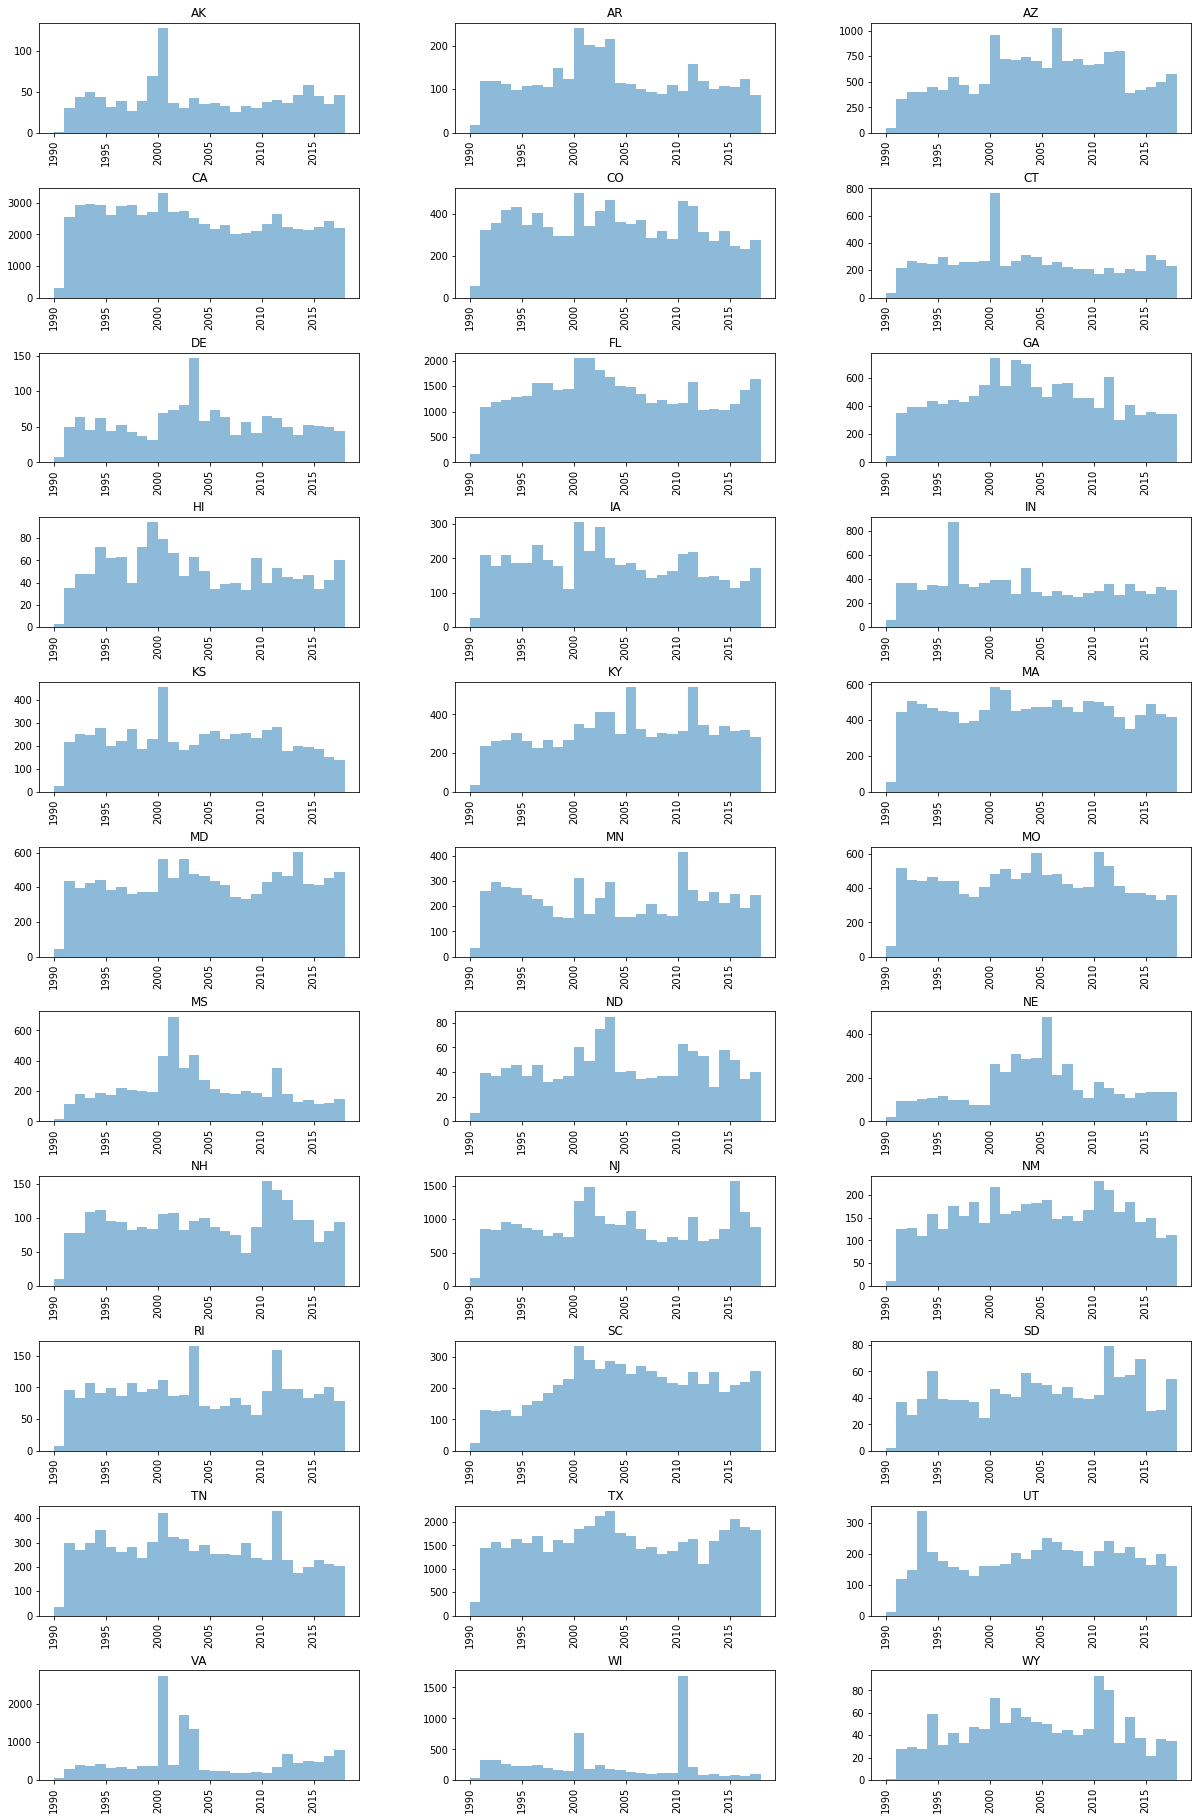

CLUSTER 1


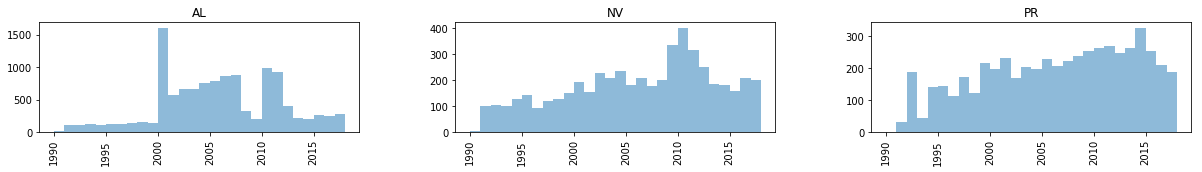

CLUSTER 2


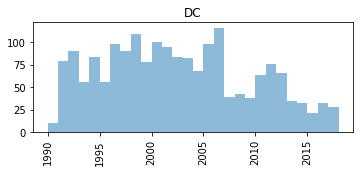

CLUSTER 3


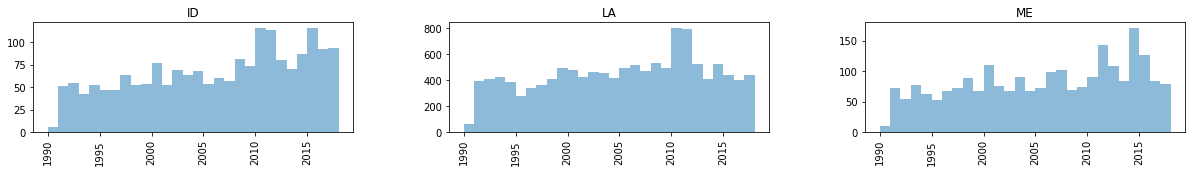

CLUSTER 4


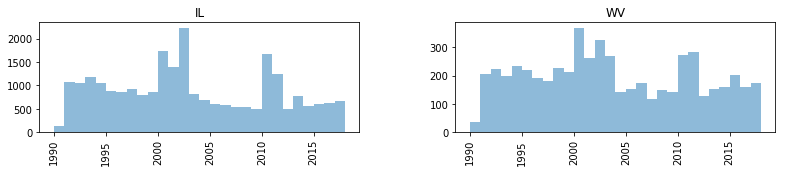

CLUSTER 5


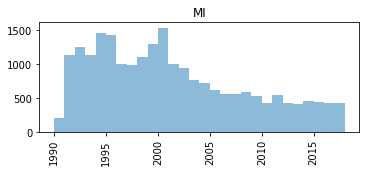

CLUSTER 6


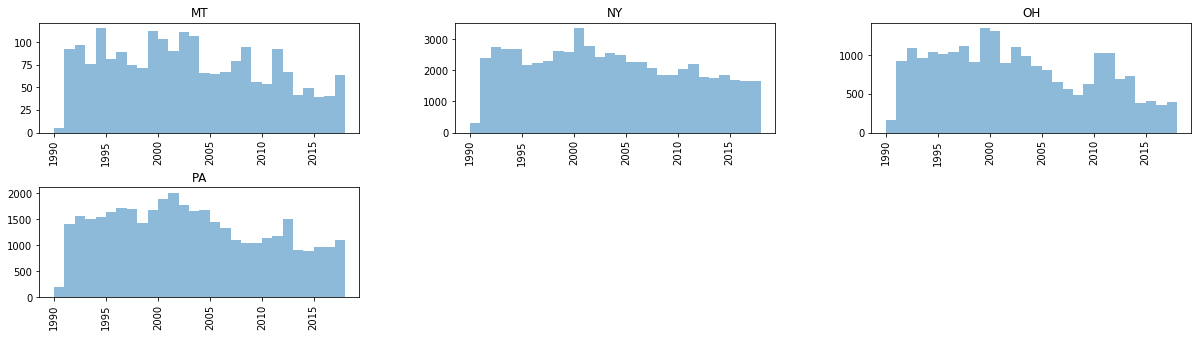

CLUSTER 7


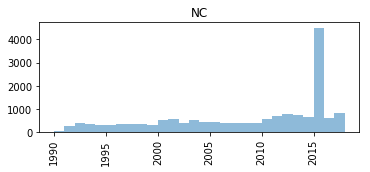

CLUSTER 8


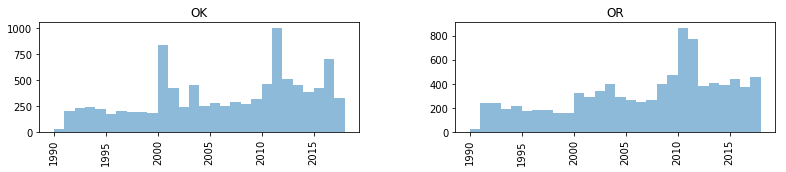

CLUSTER 9


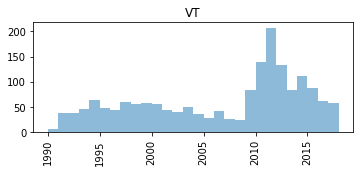

CLUSTER 10


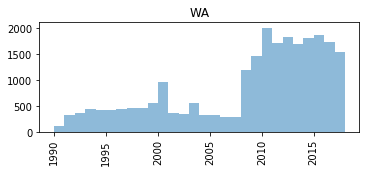

In [18]:
for i in range(len(np.unique(db))):
    print("CLUSTER "+str(i))
    data[data["WORKSTAT"].isin(list(common_states[np.where(db==i)]))].hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,60),layout=(20,3))
    plt.show()

In [19]:
from bokeh.io import show, save, output_notebook, export_png
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    ContinuousColorMapper,
    LabelSet,
    Label,
    LogColorMapper, 
    LogTicker, 
    FixedTicker,
    ColorBar, 
    LinearColorMapper,
    Legend
)
from bokeh.plotting import figure, output_file, show
## This is where we get the state data from:
from bokeh.sampledata.us_states import data as states
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.palettes import PRGn11 as palette
from bokeh.palettes import Category20,Spectral11,Category10,PRGn11

In [20]:
try:
    del states["HI"]
    del states["AK"]
except:
    pass

palette.reverse()

states = {
    code: state for code, state in states.items()
}
#print(states)

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]
state_names = [state['name'] for state in states.values()]

state_rates = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_rates.append(float(df_state_slope[df_state_slope["state"]==abbr]["slope"]))
    
state_abbr = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_abbr.append(abbr)
    
#print(state_rates)

lat_inkm = 111.132 ## at around lat = 45degrees from the wiki latitude page
lon_inkm = 78.847 ## at around lat = 45degrees from the wiki latitude page

In [21]:
text_position_x = []
for statex in state_xs:
    text_position_x.append(float("%.5f" % round(max(statex)-(max(statex)-min(statex))/2,5)))
    
text_position_y = []
for statey in state_ys:
    text_position_y.append(float("%.5f" % round(max(statey)-(max(statey)-min(statey))/2,5)))

In [22]:
state_clusters=[]
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_clusters.append(palette[int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cl_colors"])])

state_clusters

['#d9f0d3',
 '#e7d4e8',
 '#e7d4e8',
 '#e7d4e8',
 '#e7d4e8',
 '#e7d4e8',
 '#e7d4e8',
 '#f7f7f7',
 '#e7d4e8',
 '#9970ab',
 '#e7d4e8',
 '#e7d4e8',
 '#d9f0d3',
 '#e7d4e8',
 '#e7d4e8',
 '#e7d4e8',
 '#9970ab',
 '#e7d4e8',
 '#5aae61',
 '#e7d4e8',
 '#40004b',
 '#e7d4e8',
 '#1b7837',
 '#e7d4e8',
 '#f7f7f7',
 '#e7d4e8',
 '#762a83',
 '#e7d4e8',
 '#e7d4e8',
 '#e7d4e8',
 '#a6dba0',
 '#e7d4e8',
 '#e7d4e8',
 '#e7d4e8',
 '#f7f7f7',
 '#e7d4e8',
 '#e7d4e8',
 '#9970ab',
 '#e7d4e8',
 '#e7d4e8',
 '#c2a5cf',
 '#00441b',
 '#e7d4e8',
 '#a6dba0',
 '#c2a5cf',
 '#e7d4e8',
 '#e7d4e8',
 '#9970ab',
 '#e7d4e8']

In [23]:
cluster_label = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    cluster_label.append(int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cl_colors"])+1)

#cluster_label

In [24]:
import pickle
print(pickle.compatible_formats)

['1.0', '1.1', '1.2', '1.3', '2.0', '3.0', '4.0']


In [25]:
state_xs

[[-114.04392,
  -114.04558,
  -114.04619,
  -114.04644,
  -114.04658,
  -114.04727,
  -114.04757,
  -114.0473,
  -114.04779,
  -114.04841,
  -114.04885,
  -114.04833,
  -114.04916,
  -114.04992,
  -114.04997,
  -114.05013,
  -114.04939,
  -114.05198,
  -114.05264,
  -114.05187,
  -114.0506,
  -114.0506,
  -114.05014,
  -114.04736,
  -114.04338,
  -114.04404,
  -114.1139,
  -114.22646,
  -114.32346,
  -114.51122,
  -114.6729,
  -114.73513,
  -114.74365,
  -114.70883,
  -114.67489,
  -114.70415,
  -114.69704,
  -114.68702,
  -114.65449,
  -114.66076,
  -114.6768,
  -114.61121,
  -114.58031,
  -114.57354,
  -114.63064,
  -114.60899,
  -114.63423,
  -114.63349,
  -114.63361,
  -114.82052,
  -115.11622,
  -115.36992,
  -115.65233,
  -115.89512,
  -116.08072,
  -116.37528,
  -116.87227,
  -117.31883,
  -117.79563,
  -118.04392,
  -118.22972,
  -118.51722,
  -119.00097,
  -119.43506,
  -119.76041,
  -119.9748,
  -120.00608,
  -120.0015,
  -120.00049,
  -119.99733,
  -119.99567,
  -119.99926,


In [26]:
pickle.dump(state_xs, open("state_xs.pck", "wb"))
pickle.dump(state_ys, open("state_ys.pck", "wb"))
pickle.dump(state_names, open("state_names.pck", "wb"))
pickle.dump(state_rates, open("state_rates.pck", "wb"))
pickle.dump(state_clusters, open("state_clusters.pck", "wb"))
pickle.dump(cluster_label, open("cluster_label.pck", "wb"))

state_xs = pickle.load(open("state_xs.pck", "rb"))
state_ys = pickle.load(open("state_ys.pck", "rb"))
state_names = pickle.load(open("state_names.pck", "rb"))
state_rates = pickle.load(open("state_rates.pck", "rb"))
state_clusters = pickle.load(open("state_clusters.pck", "rb"))
cluster_label = pickle.load(open("cluster_label.pck", "rb"))

In [27]:
output_notebook()

color_mapper = LinearColorMapper(palette=palette, low=min(state_rates), high=max(np.unique(state_rates)))

source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    rate=state_rates,
    clusters=state_clusters,
    cluster_label=cluster_label,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(title="Change in the number of malpractice cases filed per a million citizens per states, 1990-2018", 
    plot_width=int((max(max(state_xs))-min(min(state_xs)))*lon_inkm/4.5), 
    plot_height=int((max(max(state_ys))-min(min(state_ys)))*lat_inkm/4.5), tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color='clusters',
          fill_alpha=0.7, line_color="gray", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, #ticker=FixedTicker(ticks=np.unique(cluster_label)),
                     label_standoff=12, border_line_color=None, location=(0,0),major_label_text_font_size="14pt")

p.add_layout(color_bar, 'right')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips ="""
    <font size="3">State: <strong>@name</strong> </font> <br>
    <font size="3">Change in the number of   </font> <br>
    <font size="3">malpractice cases: <strong>@rate per 1,000,000</strong> </font> <br>
    <font size="3">Ranking: <strong>@cluster_label</strong> </font>
"""
show(p)

#output_file("malpractice_by_state.html",title="Malpractice by state")
#save(p, filename="malpractice_by_state.html", title="Malpractice by state", resource='cdn')


Loading BokehJS ...

In [28]:
pickle.dump(df_state_slope_cluster_aslope_acolor, open("df_state_slope_cluster_aslope_acolor.pck", "wb"))
pickle.dump(pay_count, open("pay_count.pck", "wb"))

df_state_slope_cluster_aslope_acolor = pickle.load(open("df_state_slope_cluster_aslope_acolor.pck", "rb"))
pay_count = pickle.load(open("pay_count.pck", "rb"))

In [29]:
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Select
from bokeh.plotting import Figure, output_file, show
from bokeh.layouts import column, gridplot

output_file("js_on_change.html")

def create_plot(ranking):
    p = figure(plot_width=450, plot_height=450, x_axis_label='Years', y_axis_label='Malpractice cases filed per 1,000,000')
    cur_states = list(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["cl_colors"]==ranking]["state"])
    states_title = str()
    for x in cur_states:
        states_title = states_title+x+', '
    
    if len(cur_states)>8:
        cur_states = np.random.choice(cur_states,size=8,replace=False)
        states_title = str()
        for x in cur_states:
            states_title = states_title+x+', '
        p.title.text = states_title[:-2]+" among others (Ranking "+str(ranking)+")."
    else:
        p.title.text = states_title[:-2]+" (Ranking "+str(ranking)+")."
    
    for state, color in zip(cur_states, Category20[20]):
        curve = pay_count[state,"count_per_1000000"]
        #plt.plot(range(1990,2018),curve,label=state,marker='.')
        p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
               muted_color=color, muted_alpha=0.2, legend=state)
    p.legend.location = "top_right"
    p.legend.click_policy="mute"
    return(p)

plot0 = create_plot(ranking=0)
plot1 = create_plot(ranking=1)

plot2 = create_plot(ranking=2)
plot3 = create_plot(ranking=3)


plot4 = create_plot(ranking=4)
plot5 = create_plot(ranking=5)


plot6 = create_plot(ranking=6)
plot7 = create_plot(ranking=7)


plot8 = create_plot(ranking=8)
plot9 = create_plot(ranking=9)


plot10 = create_plot(ranking=10)

#plot = gridplot([plot0,plot1],[plot2,plot3],[plot4,plot5],[plot6,plot7],[plot8,plot9],[plot10,None])
plot = gridplot([plot0,plot1,plot2],[plot3,plot4,plot5],[plot6,plot7,plot8],[plot9,plot10,None])
show(plot)

In [69]:
non_existent = ["AL", "AK", "AZ", "AR", "DE", "GA", "HI", "ID", "IA", "KY", "LA", "MS", 
                "MO", "MT", "NH", "NM", "NC", "ND", "OK", "SD", "VA", "WV", "WI"] 
mandatory = ["CA", "CO", "CT", "DC", "FL", "IL", "IN", "KS", "ME", "MD", "MA", "MN", 
             "NV", "NJ", "NY", "OH", "PA", "RI", "SC", "TN", "TX", "UT", "VT", "WA"]
partial = ["OR", "WY"]
#no_info = ["PR"]
self_organized = ["MI"]
voluntary = ["NE"]

In [70]:
df_state_slope_cluster_aslope_acolor["state"]

0     AK
1     AL
2     AR
3     AZ
4     CA
5     CO
6     CT
7     DC
8     DE
9     FL
10    GA
11    HI
12    IA
13    ID
14    IL
15    IN
16    KS
17    KY
18    LA
19    MA
20    MD
21    ME
22    MI
23    MN
24    MO
25    MS
26    MT
27    NC
28    ND
29    NE
30    NH
31    NJ
32    NM
33    NV
34    NY
35    OH
36    OK
37    OR
38    PA
39    PR
40    RI
41    SC
42    SD
43    TN
44    TX
45    UT
46    VA
47    VT
48    WA
49    WI
50    WV
51    WY
Name: state, dtype: object

In [73]:
ordered_mandatory = []
for state in list(df_state_slope_cluster_aslope_acolor["state"]):
    #print(state)
    if state in non_existent:
        ordered_mandatory.append('No')
    elif state in mandatory:
        ordered_mandatory.append('Yes')
    elif state in partial:
        ordered_mandatory.append('Partially')
    elif state in voluntary:
        ordered_mandatory.append('Voluntary')
    elif state in self_organized:
        ordered_mandatory.append('Self Org.')
    #elif state in no_info:
    #    ordered_mandatory.append('NA')
    else:
        print("ERROR")

ERROR


In [74]:
ordered_mandatory

['No',
 'No',
 'No',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'Self Org.',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'No',
 'Voluntary',
 'No',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'Partially',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'No',
 'No',
 'Partially']

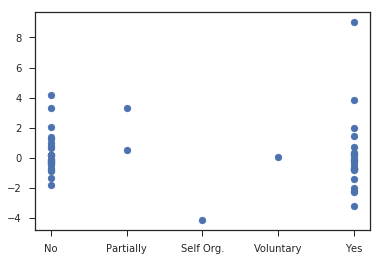

In [76]:
plt.scatter(ordered_mandatory,list(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), marker='o')
plt.show()

In [77]:
slope_mandatory = pd.DataFrame(np.stack([np.array(df_state_slope_cluster_aslope_acolor["state"].drop([39])),
                                         np.array(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), 
                                         np.array(df_state_slope_cluster_aslope_acolor["cl_colors"].drop([39])),
                                         np.array(ordered_mandatory)]).T, columns=['state','slope',"ranking","mandatory"])

In [79]:
slope_mandatory

state      slope ranking  mandatory
0     AK  -0.203255       4         No
1     AL    2.02521       6         No
2     AR  -0.317074       4         No
3     AZ   0.962205       4         No
4     CA  -0.782451       4        Yes
5     CO  -0.664984       4        Yes
6     CT  -0.742375       4        Yes
7     DC   -3.22382       1        Yes
8     DE  -0.160951       4         No
9     FL  -0.289428       4        Yes
10    GA  -0.273324       4         No
11    HI  -0.442312       4         No
12    IA    -0.8022       4         No
13    ID    1.25101       5         No
14    IL   -1.44662       3        Yes
15    IN   -0.77497       4        Yes
16    KS  -0.851088       4        Yes
17    KY   0.766673       4         No
18    LA    1.38579       5         No
19    MA  -0.172796       4        Yes
20    MD   0.315273       4        Yes
21    ME    1.44202       5        Yes
22    MI   -4.13613       0  Self Org.
23    MN  -0.105733       4        Yes
24    MO  -0.400788       4         No
25    MS  -0.872224       4         No
26    MT   -1.83996       2         No
27    NC    4.17071       9         No
28    ND     0.1917       4         No
29    NE  0.0271529       4  Voluntary
30    NH   0.182492       4         No
31    NJ   0.197119       4        Yes
32    NM   0.198316       4         No
33    NV      1.949       6        Yes
34    NY   -2.04095       2        Yes
35    OH   -2.26163       2        Yes
36    OK    3.28733       7         No
37    OR    3.31613       7  Partially
38    PA   -2.25868       2        Yes
39    RI  -0.213242       4        Yes
40    SC   0.690965       4        Yes
41    SD   0.659559       4         No
42    TN  -0.524569       4        Yes
43    TX   0.192884       4        Yes
44    UT   0.286521       4        Yes
45    VA  -0.118518       4         No
46    VT    3.85794       8        Yes
47    WA    9.00003      10        Yes
48    WI   -0.68702       4         No
49    WV   -1.38264       3         No
50    WY   0.476513       4  Partially

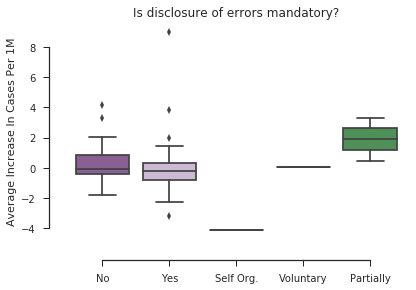

In [81]:
import seaborn as sns
sns.set(style="ticks")

sns.boxplot(x=np.array(ordered_mandatory), 
            y=np.array(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), 
            palette="PRGn", width=0.8)

sns.despine(offset=20, trim=True)
plt.title("Is disclosure of errors mandatory?")
plt.ylabel("Average Increase In Cases Per 1M") #,fontsize=14)
plt.savefig("Mandatory.png",dpi=300)

## State by state analysis of most problematic license fields:

In [38]:
data

SEQNO RECTYPE  REPTYPE  ORIGYEAR WORKSTAT  WORKCTRY HOMESTAT  \
0              1       A      301      1991       OK       NaN      NaN   
1              2       A      301      1991       OK       NaN      NaN   
2              4       A      301      1991       MA       NaN      NaN   
3              6       A      301      1990       OK       NaN      NaN   
4              8       A      301      1990       OK       NaN      NaN   
5              9       A      301      1990       OK       NaN       OK   
6             12       A      301      1990       VA       NaN       IL   
7             13       A      301      1990       KY       NaN       KY   
8             14       A      301      1990       OH       NaN      NaN   
9             15       A      301      1990       OH       NaN      NaN   
10            17       A      301      1990       VA       NaN      NaN   
11            18       A      301      1990       VA       NaN      NaN   
12            21       A      301      1990       PA       NaN      NaN   
13            22       A      301      1990       VA       NaN       VA   
14            26       A      301      1990       CA       NaN      NaN   
15            29       A      301      1990       CA       NaN      NaN   
16            30       A      301      1990       CA       NaN      NaN   
17            35       A      301      1990       IL       NaN      NaN   
18            37       A      301      1990       IL       NaN      NaN   
19            38       A      401      1990       NY       NaN       NY   
20            39       A      301      1990       WV       NaN       WV   
21            40       A      301      1990       WV       NaN       WV   
22            42       A      301      1990       CA       NaN      NaN   
23            43       A      301      1990       OH       NaN      NaN   
24            44       A      301      1990       PR       NaN      NaN   
25            45       A      301      1990       OH       NaN      NaN   
26            47       A      301      1990       OH       NaN      NaN   
27            48       A      301      1990       VA       NaN      NaN   
28            49       A      401      1990       WA       NaN      NaN   
29            50       A      401      1990       WA       NaN      NaN   
...          ...     ...      ...       ...      ...       ...      ...   
1351372  1697523       C      302      2015      NaN       NaN       AR   
1351373  1697524       C      302      2017      NaN       NaN       AR   
1351374  1697525       C      302      2017      NaN       NaN       CT   
1351375  1697526       C      302      2016      NaN       NaN       OR   
1351376  1697527       C      302      2017      NaN       NaN       MO   
1351377  1697528       C      302      2017      NaN       NaN       OR   
1351378  1697529       C      302      2016      NaN       NaN       OR   
1351379  1697530       C      302      2017      NaN       NaN       OR   
1351380  1697531       C      302      2017      NaN       NaN       OR   
1351381  1697532       C      302      2017       WA       NaN       WA   
1351382  1697533       C      302      2017       WA       NaN       WA   
1351383  1697534       C      302      2017       WA       NaN       WA   
1351384  1697535       C      302      2017       WA       NaN       WA   
1351385  1697536       C      302      2017       WA       NaN       WA   
1351386  1697537       C      302      2017       WA       NaN       WA   
1351387  1697538       C      302      2017       WA       NaN       WA   
1351388  1697539       C      302      2017       WA       NaN       WA   
1351389  1697540       P      101      2017       PR       NaN       PR   
1351390  1697541       C      302      2017      NaN       NaN       NV   
1351391  1697542       C      302      2017      NaN       NaN       NV   
1351392  1697543       C      302      2017      NaN       NaN       NV   
1351393  1697544       C      302   

In [39]:
licnfeld = pd.read_csv('license_fields.csv',delimiter=',',low_memory=False)[["Value","Label"]]
licnfeld_dict = licnfeld.to_dict(orient='split')
np.array(licnfeld_dict['data'])

array([['10', 'Allopathic Physician (MD)'],
       ['15', 'Physician Resident (MD)'],
       ['20', 'Osteopathic Physician (DO)'],
       ['25', 'Osteopathic Physician Resident (DO)'],
       ['30', 'Dentist'],
       ['35', 'Dental Resident'],
       ['50', 'Pharmacist'],
       ['55', 'Pharmacy Intern '],
       ['60', 'Pharmacist, Nuclear'],
       ['70', 'Pharmacy Assistant'],
       ['75', 'Pharmacy Technician '],
       ['76', 'Other Pharmacy Service Occupation'],
       ['100', 'Registered Nurse'],
       ['110', 'Nurse Anesthetist'],
       ['120', 'Nurse Midwife'],
       ['130', 'Nurse Practitioner'],
       ['134', 'Doctor of Nursing Practice '],
       ['135', 'Advanced Nurse Practitioner '],
       ['140', 'LPN or Vocational Nurse'],
       ['141', 'Clinical Nurse Specialist '],
       ['142', 'Other Nurse Occupation'],
       ['148', 'Certified Nurse Aide/Nursing Assistant '],
       ['150', 'Nurse Aide/Nursing Assistant'],
       ['160', 'Home Health Aide (Homemaker)'],


In [40]:
dict_fin = {}
for element in licnfeld_dict['data']:
    dict_fin[element[0]] = element[1]

print(dict_fin)

{10: 'Allopathic Physician (MD)', 15: 'Physician Resident (MD)', 20: 'Osteopathic Physician (DO)', 25: 'Osteopathic Physician Resident (DO)', 30: 'Dentist', 35: 'Dental Resident', 50: 'Pharmacist', 55: 'Pharmacy Intern ', 60: 'Pharmacist, Nuclear', 70: 'Pharmacy Assistant', 75: 'Pharmacy Technician ', 76: 'Other Pharmacy Service Occupation', 100: 'Registered Nurse', 110: 'Nurse Anesthetist', 120: 'Nurse Midwife', 130: 'Nurse Practitioner', 134: 'Doctor of Nursing Practice ', 135: 'Advanced Nurse Practitioner ', 140: 'LPN or Vocational Nurse', 141: 'Clinical Nurse Specialist ', 142: 'Other Nurse Occupation', 148: 'Certified Nurse Aide/Nursing Assistant ', 150: 'Nurse Aide/Nursing Assistant', 160: 'Home Health Aide (Homemaker)', 165: 'Health Care Aide/Direct Care Worker ', 170: 'Psychiatric Technician', 175: 'Certified or Qualified Medication Aide ', 176: 'Other Aide Occupation', 200: 'Dietitian', 210: 'Nutritionist', 211: 'Other Dietitian/Nutritionist Occupation', 250: 'EMT, Basic', 260

In [41]:
clustering_data = data.copy()
clustering_data.replace(to_replace= {'LICNFELD': dict_fin}, inplace=True)

In [42]:
clustering_data["LICNFELD"]

0             Allopathic Physician (MD)
1             Allopathic Physician (MD)
2               Physician Resident (MD)
3             Allopathic Physician (MD)
4             Allopathic Physician (MD)
5             Allopathic Physician (MD)
6             Allopathic Physician (MD)
7             Allopathic Physician (MD)
8                               Dentist
9                               Dentist
10                              Dentist
11                              Dentist
12           Osteopathic Physician (DO)
13                              Dentist
14            Allopathic Physician (MD)
15            Allopathic Physician (MD)
16            Allopathic Physician (MD)
17                              Dentist
18            Allopathic Physician (MD)
19            Allopathic Physician (MD)
20            Allopathic Physician (MD)
21            Allopathic Physician (MD)
22            Allopathic Physician (MD)
23           Osteopathic Physician (DO)
24            Allopathic Physician (MD)


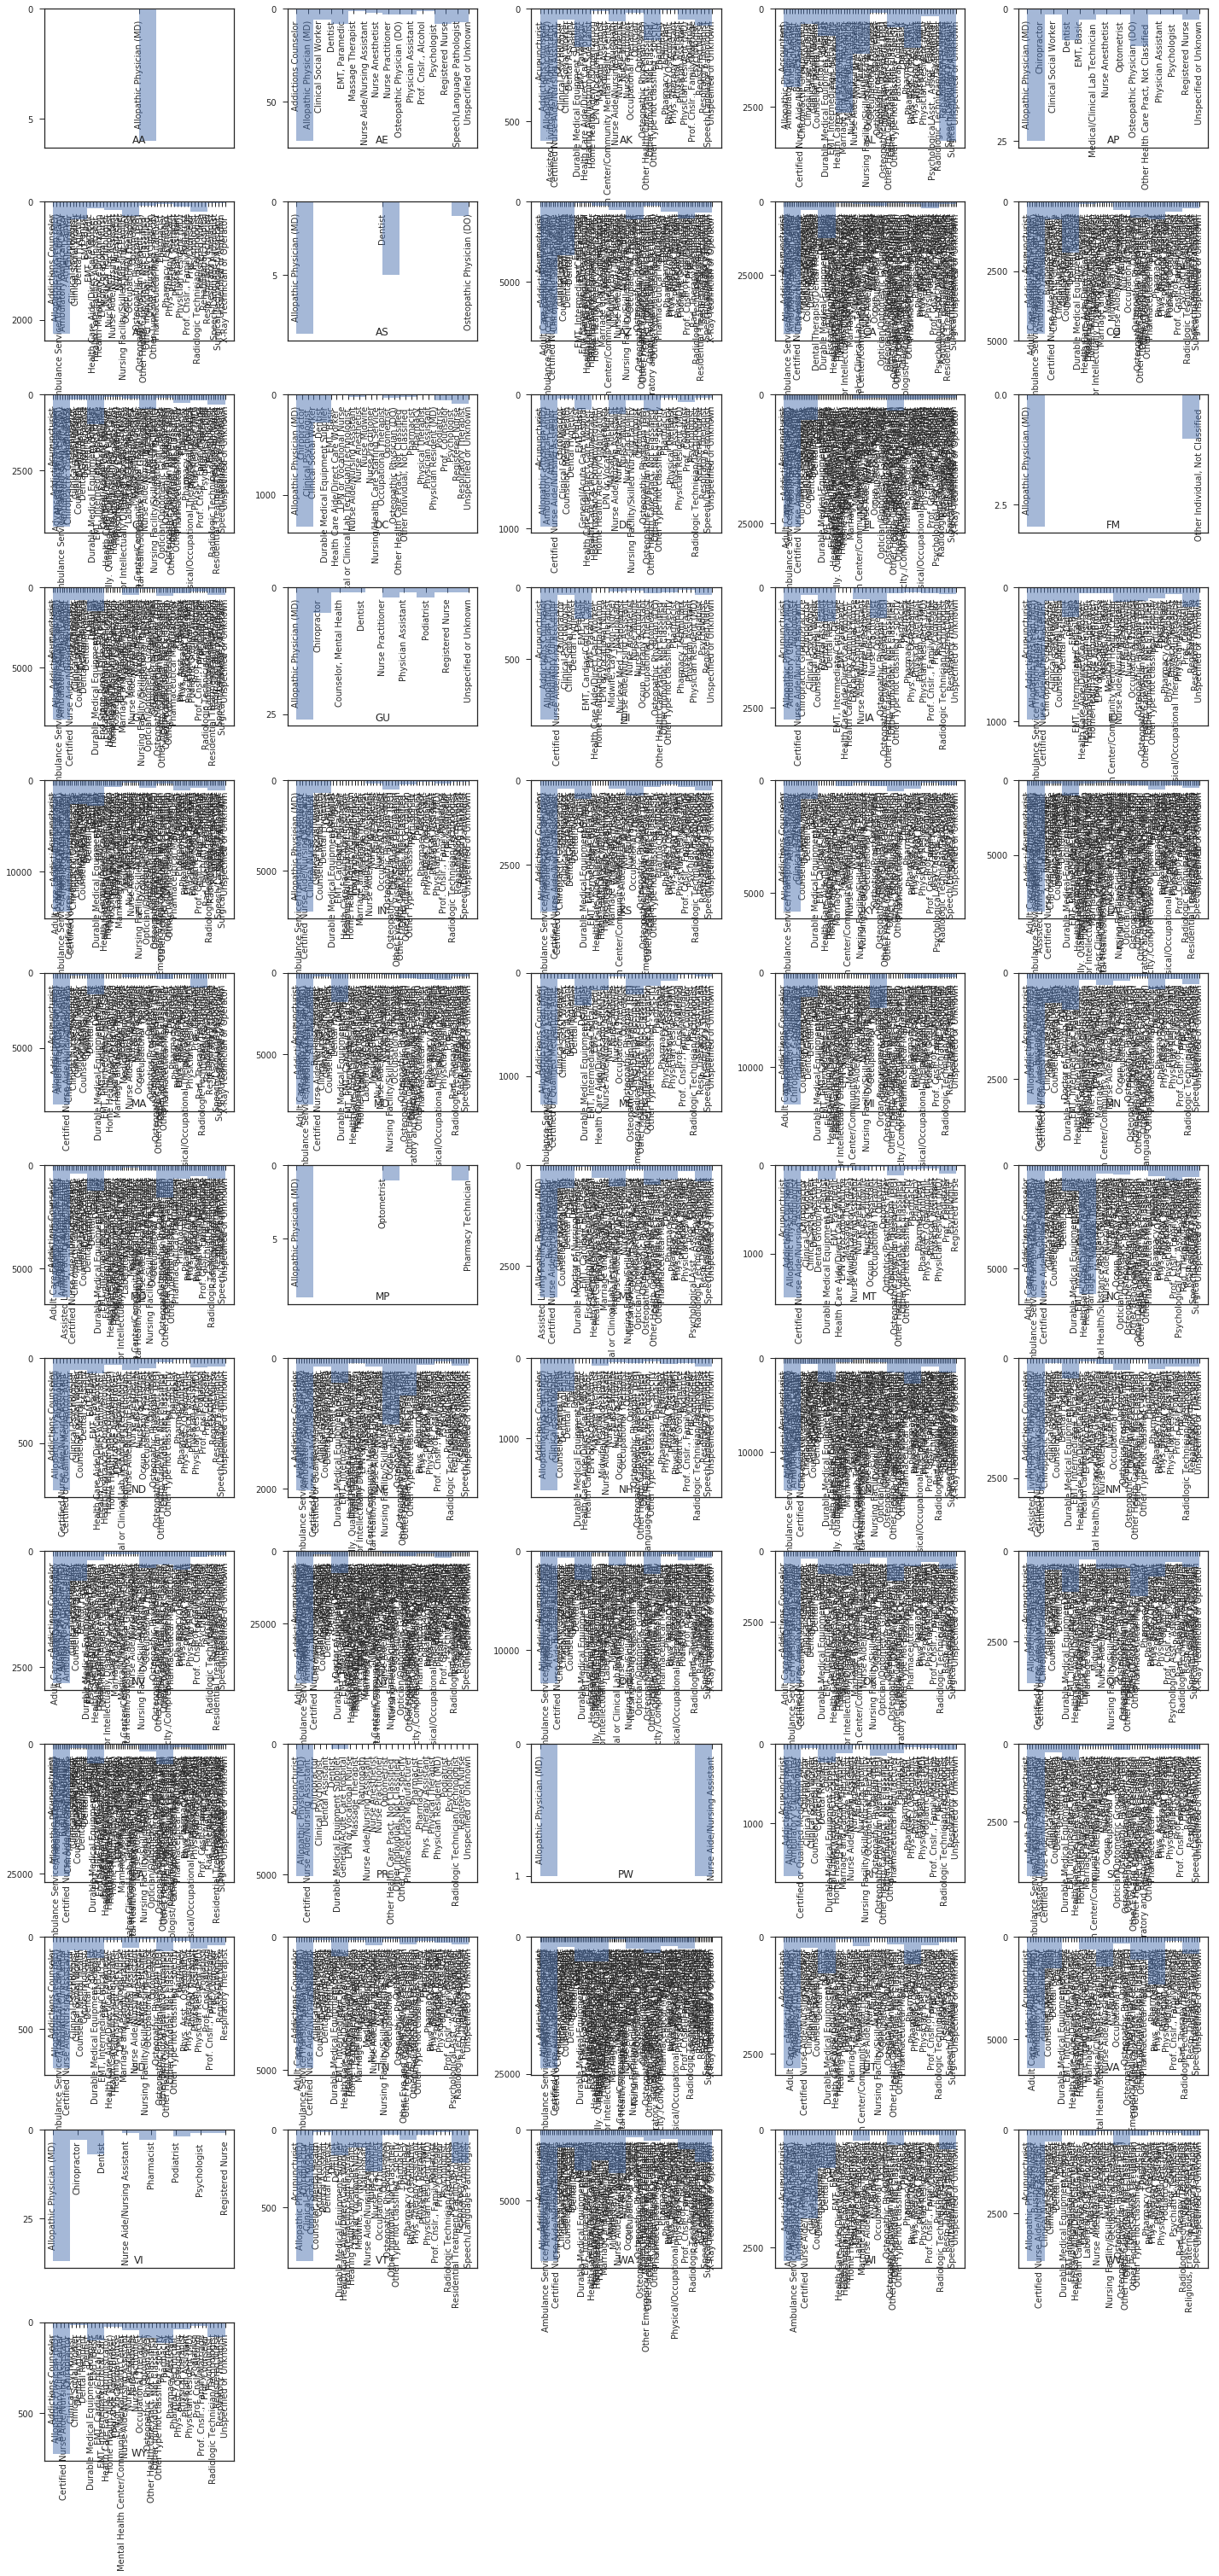

In [131]:
clustering_data.hist(column='LICNFELD',alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.xlabel('License')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('Licenses.png',dpi=300)
plt.show()

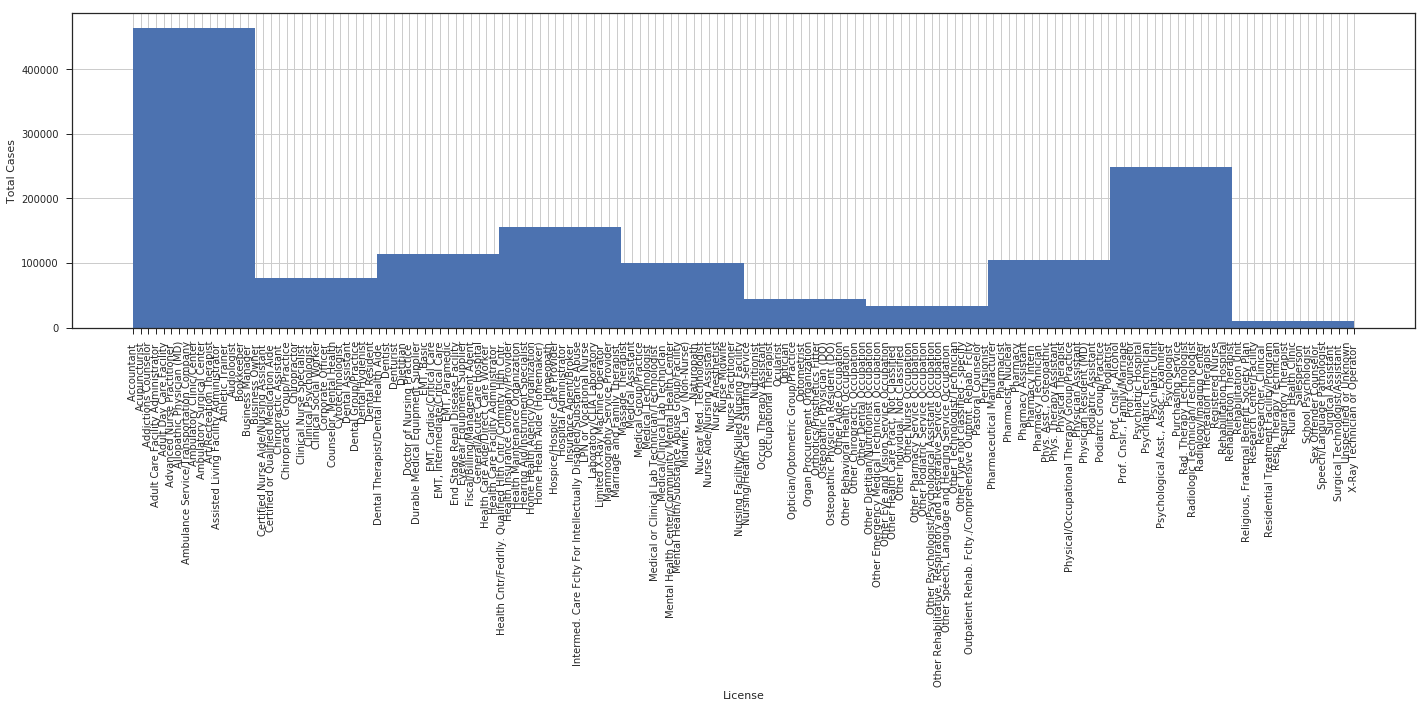

In [139]:
plt.figure(figsize=(20,10))
clustering_data['LICNFELD'].hist(bins=xrot=90)
plt.xlabel('License')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('Licenses.png',dpi=300)
plt.show()

In [141]:
np.unique(clustering_data['LICNFELD'])

array(['Accountant ', 'Acupuncturist', 'Addictions Counselor',
       'Adult Care Facility Administrator ', 'Adult Day Care Facility',
       'Advanced Nurse Practitioner ', 'Allopathic Physician (MD)',
       'Ambulance Service/Transportation Company',
       'Ambulatory Clinic/Center', 'Ambulatory Surgical Center',
       'Art/Recreation Therapist',
       'Assisted Living Facility Administrator ', 'Athletic Trainer ',
       'Audiologist', 'Bookkeeper', 'Business Manager ',
       'Business Owner ', 'Certified Nurse Aide/Nursing Assistant ',
       'Certified or Qualified Medication Aide ',
       'Chiropractic Assistant ', 'Chiropractic Group/Practice',
       'Chiropractor', 'Clinical Nurse Specialist ',
       'Clinical Psychologist ', 'Clinical Social Worker',
       'Corporate Officer ', 'Counselor, Mental Health',
       'Cytotechnologist ', 'Dental Assistant', 'Dental Group/Practice',
       'Dental Hygienist', 'Dental Resident',
       'Dental Therapist/Dental Health Aide ',

In [182]:
pickle.dump(clustering_data[["LICNFELD","WORKSTAT"]], open("clustering_data.pck", "wb"))

In [179]:
def license_bar_plot(df,upto=20,save=None):
    lic_list = []
    count = []
    for license in np.unique(df['LICNFELD']):
        lic_list.append(license)
        count.append(len(df[df['LICNFELD']==license]))
    lic_count = pd.DataFrame(np.array(count).T,columns=['count'],index=lic_list)
    lic_count.sort_values('count',inplace=True,ascending=False)
    lic_count[:upto].plot(kind='bar',figsize=(20,10))
    if save!=None:
        plt.savefig(save, dpi=300)
    plt.show()
    return lic_count

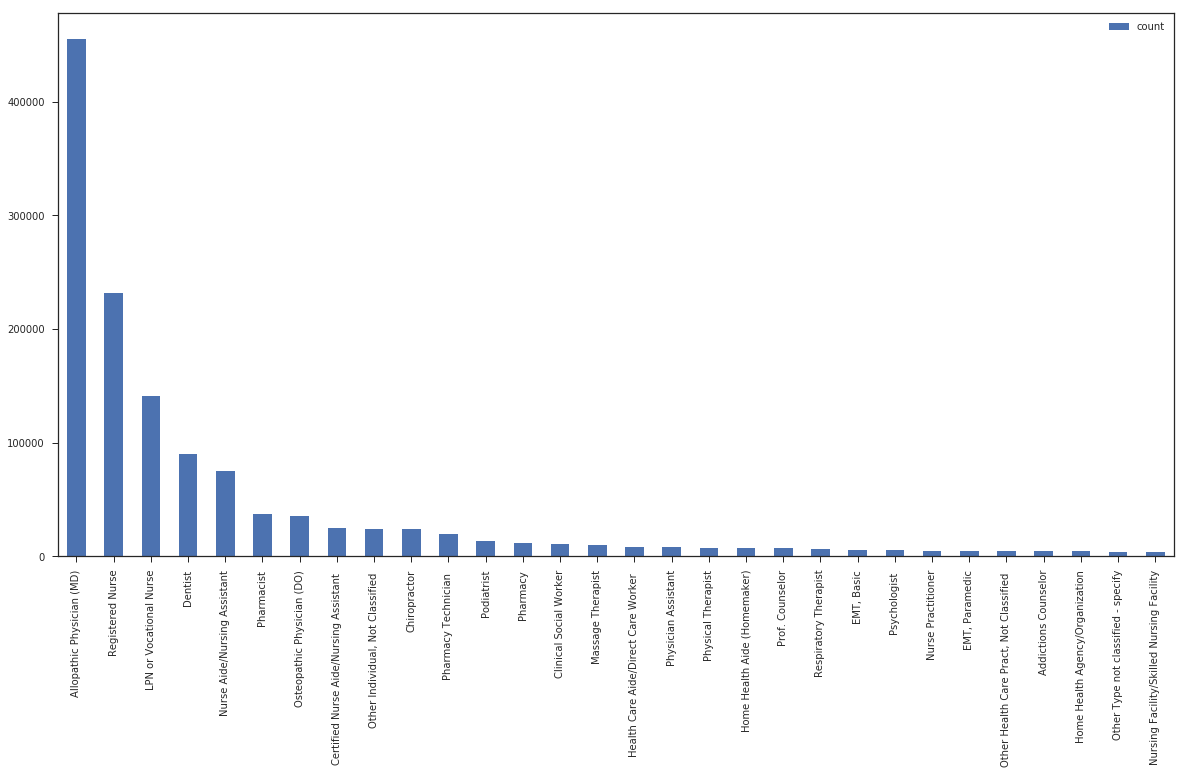

count
Allopathic Physician (MD)                           455433
Registered Nurse                                    231925
LPN or Vocational Nurse                             140851
Dentist                                              89638
Nurse Aide/Nursing Assistant                         75341
Pharmacist                                           37316
Osteopathic Physician (DO)                           35880
Certified Nurse Aide/Nursing Assistant               25024
Other Individual, Not Classified                     23878
Chiropractor                                         23819
Pharmacy Technician                                  19339
Podiatrist                                           13091
Pharmacy                                             11759
Clinical Social Worker                               10896
Massage Therapist                                     9971
Health Care Aide/Direct Care Worker                   8562
Physician Assistant                                   8145
Physical Therapist                                    7130
Home Health Aide (Homemaker)                          7113
Prof. Counselor                                       6997
Respiratory Therapist                                 6570
EMT, Basic                                            5539
Psychologist                                          5326
Nurse Practitioner                                    4978
EMT, Paramedic                                        4724
Other Health Care Pract, Not Classified               4694
Addictions Counselor                                  4536
Home Health Agency/Organization                       4517
Other Type not classified - specify                   3870
Nursing Facility/Skilled Nursing Facility             3844
...                                                    ...
Outpatient Rehab. Fclty./Comprehensive Outptnt....      22
Fiscal/Billing/Management Agent                         22
Health Insurance Company/Provider                       22
Art/Recreation Therapist                                20
Other Dietitian/Nutritionist Occupation                 18
Other Speech, Language and Hearing Service Occu...      17
Other Psychologist/Psychological Assistant Occu...      17
Other Chiropractic Occupation                           16
Homeopath                                               16
Eyewear Equipment Supplier                              15
Cytotechnologist                                        13
Sex Offender Counselor                                  11
Health Cntr/Fedrlly. Qualified Hlth Cntr./Cmmnt...      11
Nursing/Health Care Staffing Service                    11
Surgical Assistant                                      10
Limited X-Ray Machine Operator                           8
Advanced Nurse Practitioner                              8
Health Maintenance Organization                          6
Rural Health Clinic                                      6
Purchasing Service                                       6
Research Center/Facility                                 5
Doctor of Nursing Practice                               5
Mammography Service Provider                             4
Rehabilitation Unit                                      4
Dental Therapist/Dental Health Aide                      3
Psychiatric Unit                                         3
Recreation Therapist                                     2
Pastoral Counselor                                       2
Religious, Fraternal Benefit Society Plan                1
Organ Procurement Organization                           1

[160 rows x 1 columns]

In [177]:
license_bar_plot(clustering_data,upto=30,save="risky_fields.png")

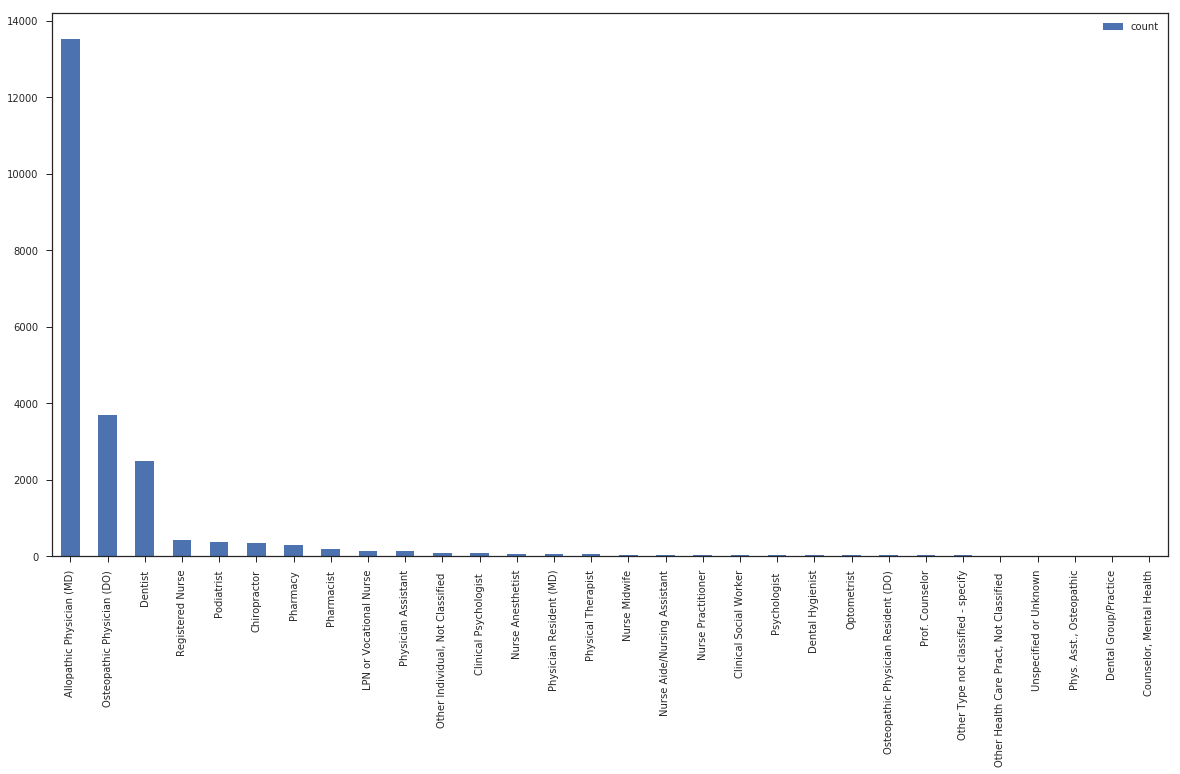

In [181]:
lic_count_MI = license_bar_plot(clustering_data[clustering_data['WORKSTAT']=="MI"][["LICNFELD","WORKSTAT"]],upto=30)

In [171]:
lic_count_MI.index

Index(['Allopathic Physician (MD)', 'Osteopathic Physician (DO)', 'Dentist',
       'Registered Nurse', 'Podiatrist', 'Chiropractor', 'Pharmacy',
       'Pharmacist', 'LPN or Vocational Nurse', 'Physician Assistant',
       'Other Individual, Not Classified ', 'Clinical Psychologist ',
       'Nurse Anesthetist', 'Physician Resident (MD)', 'Physical Therapist',
       'Nurse Midwife', 'Nurse Aide/Nursing Assistant', 'Nurse Practitioner',
       'Clinical Social Worker', 'Psychologist ', 'Dental Hygienist',
       'Optometrist', 'Osteopathic Physician Resident (DO)', 'Prof. Counselor',
       'Other Type not classified - specify',
       'Other Health Care Pract, Not Classified ', 'Unspecified or Unknown',
       'Phys. Asst., Osteopathic', 'Dental Group/Practice',
       'Counselor, Mental Health', 'Durable Medical Equipment Supplier',
       'Nursing Facility/Skilled Nursing Facility', 'Medical Group/Practice',
       'Ambulatory Clinic/Center', 'EMT, Basic',
       'Health Care Aide/

In [175]:
list(lic_count_MI.index)[:10]

['Allopathic Physician (MD)',
 'Osteopathic Physician (DO)',
 'Dentist',
 'Registered Nurse',
 'Podiatrist',
 'Chiropractor',
 'Pharmacy',
 'Pharmacist',
 'LPN or Vocational Nurse',
 'Physician Assistant']

In [174]:
from bokeh.io import output_file, show
from bokeh.sampledata.autompg import autompg as df

p = figure(plot_width=450, plot_height=450)

p.vbar(x=list(lic_count_MI.index)[:10], width=0.5, bottom=0, top=list(lic_count_MI["count"])[:10], color="#CAB2D6")

output_file("bar.html")

show(p)

In [168]:
df

mpg  cyl  displ   hp  weight  accel  yr  origin  \
0    18.0    8  307.0  130    3504   12.0  70       1   
1    15.0    8  350.0  165    3693   11.5  70       1   
2    18.0    8  318.0  150    3436   11.0  70       1   
3    16.0    8  304.0  150    3433   12.0  70       1   
4    17.0    8  302.0  140    3449   10.5  70       1   
5    15.0    8  429.0  198    4341   10.0  70       1   
6    14.0    8  454.0  220    4354    9.0  70       1   
7    14.0    8  440.0  215    4312    8.5  70       1   
8    14.0    8  455.0  225    4425   10.0  70       1   
9    15.0    8  390.0  190    3850    8.5  70       1   
10   15.0    8  383.0  170    3563   10.0  70       1   
11   14.0    8  340.0  160    3609    8.0  70       1   
12   15.0    8  400.0  150    3761    9.5  70       1   
13   14.0    8  455.0  225    3086   10.0  70       1   
14   24.0    4  113.0   95    2372   15.0  70       3   
15   22.0    6  198.0   95    2833   15.5  70       1   
16   18.0    6  199.0   97    2774   15.5  70       1   
17   21.0    6  200.0   85    2587   16.0  70       1   
18   27.0    4   97.0   88    2130   14.5  70       3   
19   26.0    4   97.0   46    1835   20.5  70       2   
20   25.0    4  110.0   87    2672   17.5  70       2   
21   24.0    4  107.0   90    2430   14.5  70       2   
22   25.0    4  104.0   95    2375   17.5  70       2   
23   26.0    4  121.0  113    2234   12.5  70       2   
24   21.0    6  199.0   90    2648   15.0  70       1   
25   10.0    8  360.0  215    4615   14.0  70       1   
26   10.0    8  307.0  200    4376   15.0  70       1   
27   11.0    8  318.0  210    4382   13.5  70       1   
28    9.0    8  304.0  193    4732   18.5  70       1   
29   27.0    4   97.0   88    2130   14.5  71       3   
..    ...  ...    ...  ...     ...    ...  ..     ...   
362  28.0    4  112.0   88    2605   19.6  82       1   
363  27.0    4  112.0   88    2640   18.6  82       1   
364  34.0    4  112.0   88    2395   18.0  82       1   
365  31.0    4  112.0   85    2575   16.2  82       1   
366  29.0    4  135.0   84    2525   16.0  82       1   
367  27.0    4  151.0   90    2735   18.0  82       1   
368  24.0    4  140.0   92    2865   16.4  82       1   
369  36.0    4  105.0   74    1980   15.3  82       2   
370  37.0    4   91.0   68    2025   18.2  82       3   
371  31.0    4   91.0   68    1970   17.6  82       3   
372  38.0    4  105.0   63    2125   14.7  82       1   
373  36.0    4   98.0   70    2125   17.3  82       1   
374  36.0    4  120.0   88    2160   14.5  82       3   
375  36.0    4  107.0   75    2205   14.5  82       3   
376  34.0    4  108.0   70    2245   16.9  82       3   
377  38.0    4   91.0   67    1965   15.0  82       3   
378  32.0    4   91.0   67    1965   15.7  82       3   
379  38.0    4   91.0   67    1995   16.2  82       3   
380  25.0    6  181.0  110    2945   16.4  82       1   
381  38.0    6  262.0   85    3015   17.0  82       1   
382  26.0    4  156.0   92    2585   14.5  82       1   
383  22.0    6  232.0  112    2835   14.7  82       1   
384  32.0    4  144.0   96    2665   13.9  82       3   
385  36.0    4  135.0   84    2370   13.0  82       1   
386  27.0    4  151.0   90    2950   17.3  82       1   
387  27.0    4  140.0   86    2790   15.6  82       1   
388  44.0    4   97.0   52    2130   24.6  82       2   
389  32.0    4  135.0   84    2295   11.6  82       1   
390  28.0    4  120.0   79    2625   18.6  82       1   
391  31.0    4  119.0   82    2720   19.4  82       1   

                                  name  
0            chevrolet chevelle malibu  
1                    buick skylark 320  
2                   plymouth satellite  
3                        amc rebel sst  
4                          ford torino  
5                     ford galaxie 500  
6                     chevrolet impala  
7                    plymouth fury iii  
8                     pontiac catalina  
9                   amc ambassador dpl  
10                 d